In [1]:
# Load packages and data
using DelimitedFiles, LinearAlgebra, Printf, Base, Plots

data = readdlm("houseprice.csv", ',', Float64)
t = data[:, 1:end .!= 1]
y = data[:, setdiff(1:end, (2,3))]
println("Done loading")

Done loading


In [2]:
# First, we need to identify the "Fit Function" to find least squares with 
# This is an additional step to Linear Least Squares, where there's only 1 fit function possible for OLS
# We need to make an educated guess what this function is
# M = fit function; f = y - M

# Second, we optimize using least squares because we want find best "beta" parameters for the fit function M
# x is now a vector of "betas", usually starting with 1s as guesses, but we can customize 
# (y_i, t_{i,1}, t_{i,2}) are sample output y_i, and 2 sample inputs t_{i,1 and 2}
# Sum Squares fuction = F(x) = \sigma_{i=1}^{m}: (1/2)*(f(x))^2


# Then, we need to find the derivatives of M 
# Jacobian = J = g [for some people g stands for gradient]
# Hessian = H. Each entry in H: h_{i,j}= (d^{2}f)/(dx_i dx_j)


# Finally, using Taylor Series (which can represent a Sum with a function)
# F(x) = sum of least squares trying to minimize = (1/2)sigma_{i=1}^{m}: [f_i(x)]^2 
# Where: f_i = y_i - M(x, t_{i,1}, t_{i,2})

In [3]:
# Double log fitting Model, Jacobian, Hessian

function f(x)
    f = 
    x[1]*broadcast(^, exp(1), x[2]*t[:,1]) + 
    x[3]*broadcast(^, exp(1), x[4]*t[:,1]) + 
    x[5]*broadcast(^, exp(1), x[6]*t[:,2]) + 
    x[7]*broadcast(^, exp(1), x[8]*t[:,2]) + 
    x[9]*ones(size(t, 1),1) - y
end
    
function J(x)
    J = [
    ones(size(t[:,1],1));; 
    Diagonal(t[:,1])*x[1]*broadcast(^, exp(1), x[2]*t[:,1]);; 
    ones(size(t[:,1],1));; 
    Diagonal(t[:,1])*x[3]*broadcast(^, exp(1), x[4]*t[:,1]);; 
    ones(size(t[:,2],1));; 
    Diagonal(t[:,2])*x[5]*broadcast(^, exp(1), x[6]*t[:,2]);; 
    ones(size(t[:,2],1));; 
    Diagonal(t[:,2])*x[7]*broadcast(^, exp(1), x[8]*t[:,2]);; 
    ones(size(t,1));;
    ]
end

function H(x)
    H = [
    zeros(size(t[:,1],1));; 
    [zeros(1); t[2,1]^2*x[1]*broadcast(^, exp(1), x[2]*t[2,1]); zeros(size(t[:,1],1)-2)];; 
    zeros(size(t[:,1],1));; 
    [zeros(3); t[4,1]^2*x[3]*broadcast(^, exp(1), x[4]*t[4,1]); zeros(size(t[:,1],1)-4)];; 
    zeros(size(t[:,1],1));; 
    [zeros(5); t[6,2]^2*x[5]*broadcast(^, exp(1), x[6]*t[6,2]); zeros(size(t[:,1],1)-6)];; 
    zeros(size(t[:,1],1));; 
    [zeros(7); t[8,2]^2*x[7]*broadcast(^, exp(1), x[8]*t[8,2]); zeros(size(t[:,1],1)-8)];; 
    zeros(size(t[:,1],1)) 
    ]
end

x_0 = ones(9, 1)

println("Done loading")

Done loading


### LM Algo

In [4]:
function LM(x_0)
    k_max = 1000
    x = x_0
    k = 0
    g = 1
    h = 1
    v = 2
    u = 1
    Output = Float64[]
    SSE = Float64[]
    while k < k_max && norm(g, Inf) > eps(Float64) && norm(h, 2) > eps(Float64)*(norm(x, 2)*eps(Float64))
        k += 1    
        A = (transpose(J(x))*J(x))
        g = (transpose(J(x))*f(x))
        T = A + u*Matrix{Float64}(I, size(J(x),2), size(J(x),2))
        h = T\(-g)
        push!(Output, norm(h, Inf))
        push!(SSE, (transpose(f(x)-y)*(f(x)-y))[1])
        x_new = x + h
        q = (transpose(f(x))*f(x)-transpose(f(x_new))*f(x_new))/(transpose(h)*(u*h−g))
        if q[1] > 0
            x = x_new
            u = u*max(1/3, 1-(2*q[1]-1)^3)
            v = 2
        else
            u = u*v
            v = 2*v
        end
    end
    println("Completed in ", size(Output,1)," iterations")
    println("Last step infinite-norm is ", Output[size(Output,1)], " in Float64")
    println("SSE is ", SSE[size(SSE,1)])
    println("Minimum found at ", x)
    writedlm("LMnorm.csv",  Output, ',')
    writedlm("LMSSE.csv",  SSE, ',')
end

LM (generic function with 1 method)

In [5]:
LM(x_0)

Completed in 50 iterations
Last step infinite-norm is 9.610850773167171e-28 in Float64
SSE is 2.184402027921605e17
Minimum found at [221263.96745164867; -0.03485864386608018; 221263.9674516495; -0.03485866184125385; 221263.9674516523; 0.9999999999730278; 221263.96745164835; 0.9999999999730278; 221263.96745163325;;]


### DL Algo

In [6]:
# We removed constraints to iterate a bit more and compare to LM
# Can remove hashes from below and recompile if want to run more mathematically correct trust region

function DL(x_0)
    k_max = 60
    x = x_0
    k = 0
    g = 1
    Δ = 10
    Output = Float64[]
    SSE = Float64[]
    while k < k_max && norm(f(x), Inf) > eps(Float64) && norm(g, Inf) > eps(Float64)
        k += 1    
        g = transpose(J(x))*f(x)
        a = (norm(g, 2)^2)/(norm(J(x)*g, 2)^2)
        h_sd = -a*g
        h_gn = J(x)\-f(x)
        
        b_dot_a = a * dot(h_sd, h_gn)
        a_squared_norm = (a * norm(h_sd, 2))^2
        b_minus_a_squared_norm = a_squared_norm - 2 * b_dot_a + norm(h_gn,2)^2
        c =  b_dot_a - a_squared_norm
        d = ((c^2 + b_minus_a_squared_norm * (Δ^2 - a_squared_norm))^2)^(0.25)
        b = (c <= 0) ? (d - c)/ b_minus_a_squared_norm : (Δ^2 - a_squared_norm) / (d + c)
        
        if norm(h_gn, 2) <= Δ
            h_dl = h_gn
        elseif norm(a*h_sd, 2) >= Δ
            h_dl = (Δ/norm(h_sd, 2))*h_sd
        else
            h_dl = a*h_sd + b*(h_gn - a*h_sd)
        end
        
        push!(Output, norm(h_dl, Inf))
        push!(SSE, (transpose(f(x)-y)*(f(x)-y))[1]) 
        
        #if norm(h_dl, 2) <= eps(Float64)*(norm(x, 2) + eps(Float64))
        #    k = k_max
        #else
            x_new = x + h_dl
            if h_dl == h_gn
                L = 0.5*transpose(f(x_new))*f(x_new)
            elseif h_dl == (-Δ/norm(g,2))g
                L = ((2*norm(a*g,2)-Δ)*Δ)/(2*a)
            else
                L = 0.5*a*((1 - b)^2)*(norm(g,2)^2) + b*(2-b)*(0.5*transpose(f(x_new))*f(x_new))[1]
            end
            q = 0.5*(transpose(f(x))*f(x)-transpose(f(x_new))*f(x_new))/L
            
            if q[1] > 0.75
                Δ = max(Δ, 3*norm(h_dl,2))
            end
            
            if q[1] < 0.25
                Δ = Δ/2
            end

           # if Δ <= eps(Float64)*(norm(x, 2) + eps(Float64))
           #     k = k_max
           # end
            
            if q[1] > 0
                x = x_new
        
            end
        #end
    end
    println("Completed in ", size(Output,1)," iterations")
    println("Last step infinite-norm is ", Output[size(Output,1)], " in Float64")
    println("SSE is ", SSE[size(SSE,1)])
    println("Minimum found at ", x)
    writedlm("DLnorm.csv",  Output, ',')
    writedlm("DLSSE.csv",  SSE, ',')
end

DL (generic function with 1 method)

In [7]:
DL(x_0)

Completed in 60 iterations
Last step infinite-norm is 7.757919228897391e-18 in Float64
SSE is 2.403573171209492e17
Minimum found at [9.944271908957807; 0.9999983313691848; 9.944271908957807; 0.9999983313691848; 9.944271908957807; 1.0; 9.944271908957807; 1.0; 9.944271908957807;;]


## Plots

In [8]:
LMnorm = readdlm("LMnorm.csv", ',', Float64)
LMSSE = readdlm("LMSSE.csv", ',', Float64)
DLnorm = readdlm("DLnorm.csv", ',', Float64)
DLSSE = readdlm("DLSSE.csv", ',', Float64)
println("Done loading")

Done loading


#### Incremental x+h step, infinite norm of h vs iterations

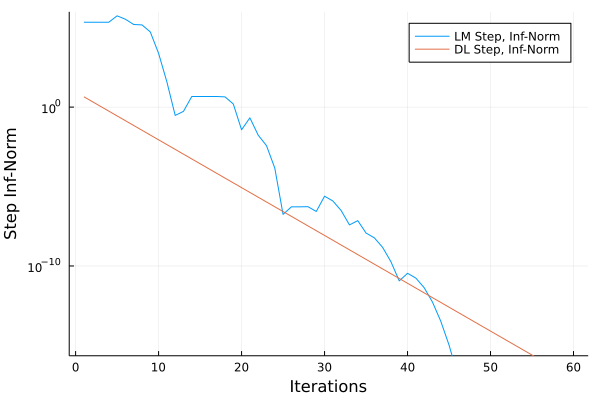

In [9]:
# Dog Leg incremental step's 2-norm reached machine precision at 56 iterations
# LM reached in 46 iterations, slightly less
# But note LM has O(m^3) higher flops per iteration

plot(1:size(LMnorm,1), LMnorm, yaxis=:log, ylims = (eps(Float64),1000000), label="LM Step, Inf-Norm", 
    xlabel = "Iterations", ylabel = "Step Inf-Norm")
plot!(1:size(DLnorm,1), DLnorm, label="DL Step, Inf-Norm")

#### SSE vs iterations

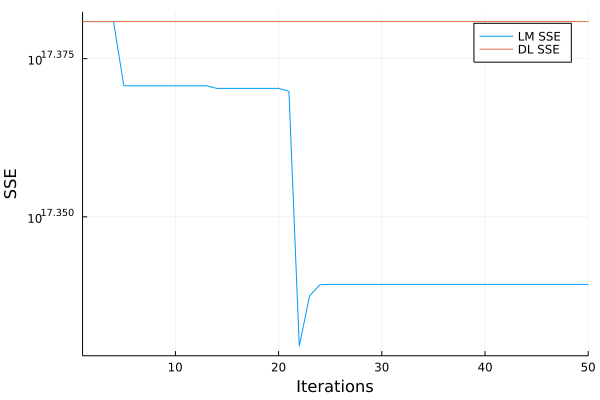

In [10]:
# Both algo's SSE are similar. With LM's SSE showing a ~9% improvement at stabilized SSE

plot(1:size(LMSSE,1), LMSSE, xlims = (1,50), yaxis=:log, label="LM SSE", 
    xlabel = "Iterations", ylabel = "SSE")
plot!(1:size(DLSSE,1), DLSSE, xlims = (1,50), label="DL SSE")